## EDA

In [1]:
from pyedflib import highlevel
import pyedflib as plib
import numpy as np
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


In [3]:
path = "../data/raw_edf/SN002.edf"
signals, signal_headers, header = highlevel.read_edf(path) # len(signal_headers) == len(signals) == 8
# len(header) == len(header_score) == 12
# len(signals[0]) == 6,566,400; len(header_score['annotations']) == 856
path2 = "../data/scoring_edf/SN002_sleepscoring.edf"
_, _, header_score = highlevel.read_edf(path2)

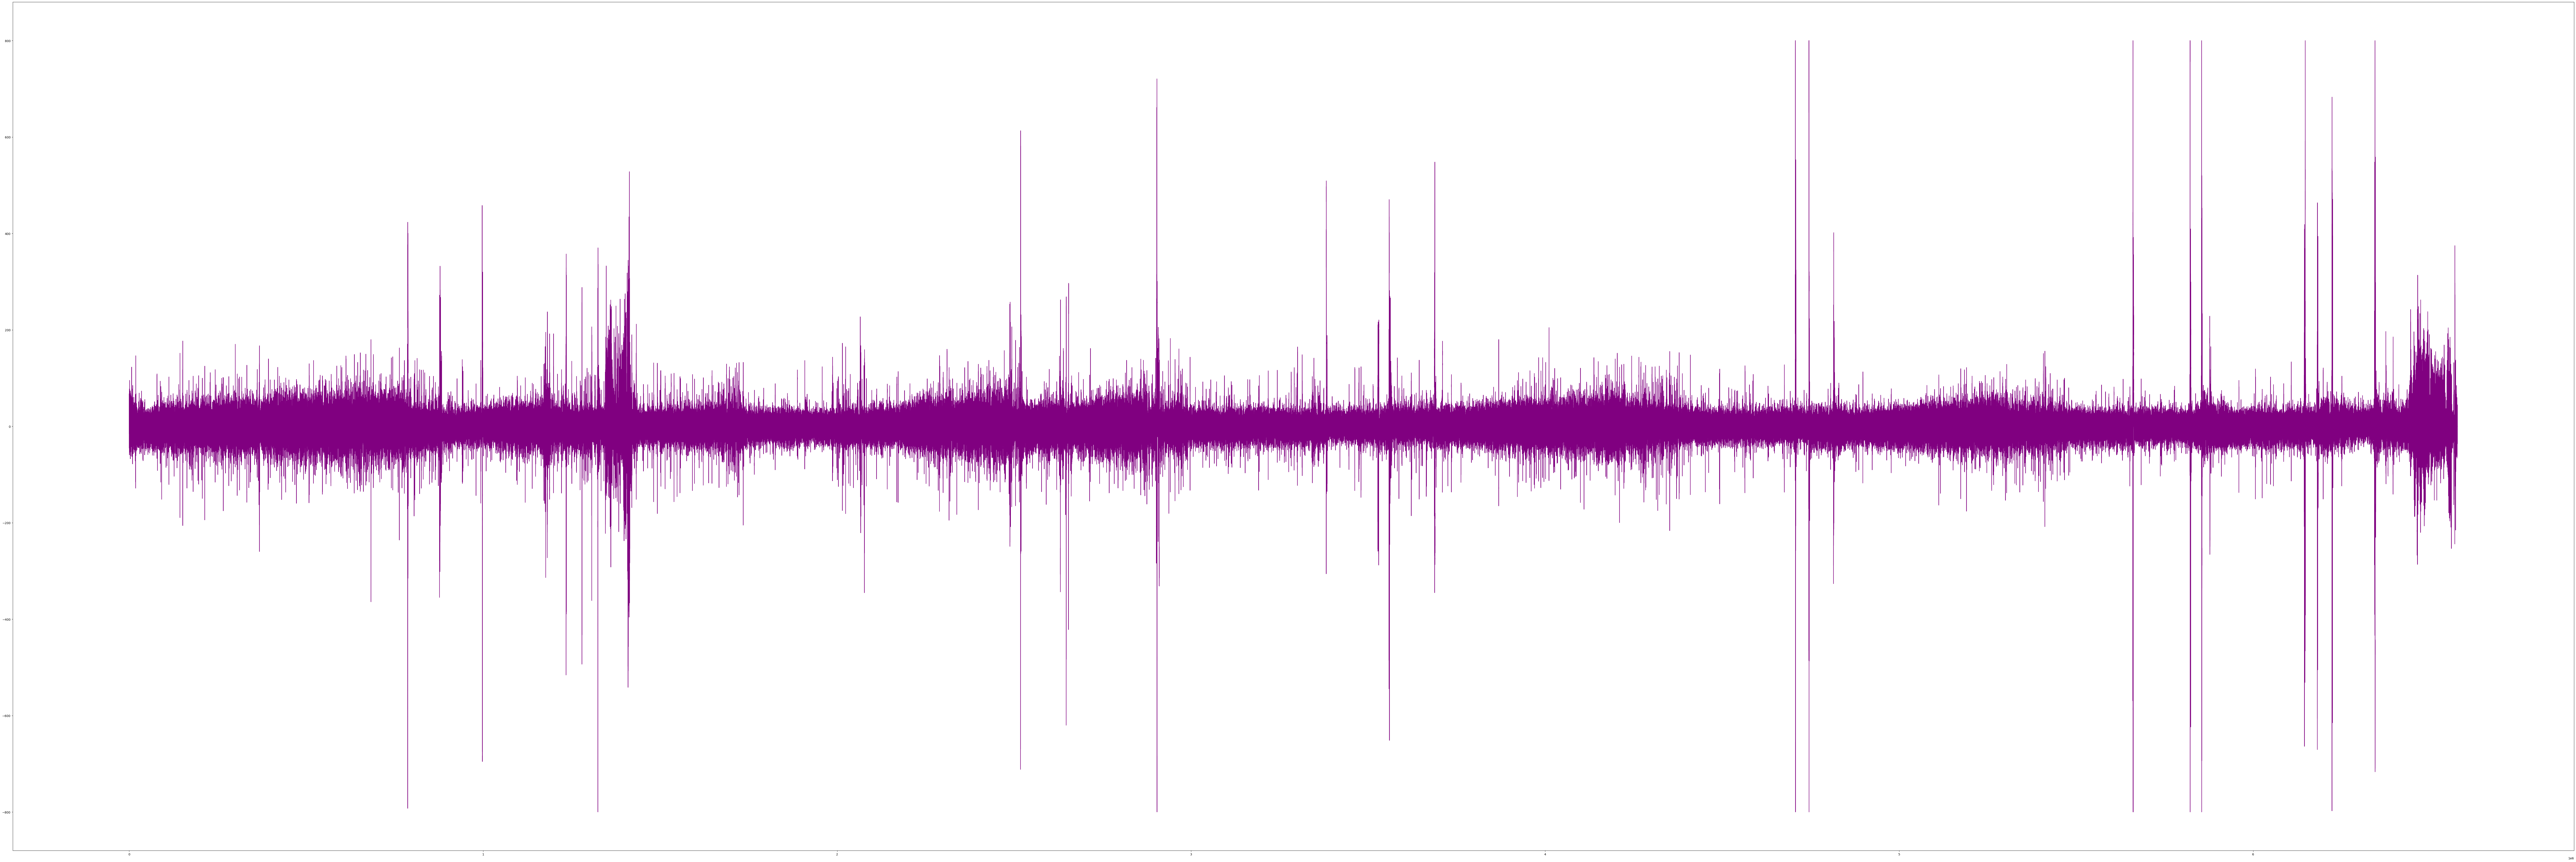

In [4]:
n = len(signals)

fig = plt.figure(figsize=(150,50))
ax = plt.axes()
for i in np.arange(n):
    ax.plot(signals[i] , color='purple' )
    plt.show()

**Signal** = One continuous voltage trace from a single sensor (e.g., “EEG F4‑C4”, EMG chin) ==> You have 8 separate traces—one per channel.

**Sample frequency (256 Hz)** = The recorder grabs 256 points every second for that channel ==> So every second of overnight data contains 256 numbers per channel  

**Sample count (6_566_400 )** = Total points collected for that channel during the whole night ==> 6_566_400 samples ÷ 256 samples/s ≈ 25_650 s of recording

**30‑s epoch (scoring block)** = Sleep technicians label the stage every 30 s ==> 256 Hz × 30 s = 7_680 samples fall into one epoch. Or, each label is 30 1 x 256 vectors









 


In [ ]:
# Strip any “Lights off@@” annotations; could be off@EEG, off@EMG, etc.
# header_score['annotations'] is a list of tuples (onset, duration, description)
header_score['annotations'] = [
    (onset, dur, desc)
    for onset, dur, desc in header_score['annotations']
    if "Lights off@@" not in desc          # substring match, case‑sensitive
]

print(len(header_score['annotations']))  

857


In [ ]:
# signals[2][0:256] # is the first second of raw voltages;
print(len(signals)) # 8 different signals
print(len(signals[0])) # 6_566_400 samples per signal
print(len(header_score['annotations'])) # 855 annotations

In [9]:
chan_idx = 0  
sr = signal_headers[chan_idx]['sample_frequency'] # e.g. 256.0 Hz
epoch_len = int(30 * sr) # 7680.0 samples per epoch
# 30 seconds per epoch
# 6_566_400 samples / 7680.0 samples per epoch == 855 epochs
# 6_566_400 samples / 256.0 samples per second == 25_600 seconds
# 25_600 seconds / 60 seconds per minute == 426.6666666666667 minutes
# 426.6666666666667 minutes / 60 minutes per hour == 7.111111111111111 hours
n_epochs = int(len(signals[0]) // epoch_len) # 6_566_400 // 7680.0 == 855

In [30]:
header_score['annotations']

[(np.float64(0.0), np.float64(30.0), np.str_('Sleep stage W')),
 (np.float64(30.0), np.float64(30.0), np.str_('Sleep stage W')),
 (np.float64(60.0), np.float64(30.0), np.str_('Sleep stage W')),
 (np.float64(90.0), np.float64(30.0), np.str_('Sleep stage W')),
 (np.float64(120.0), np.float64(30.0), np.str_('Sleep stage W')),
 (np.float64(150.0), np.float64(30.0), np.str_('Sleep stage W')),
 (np.float64(180.0), np.float64(30.0), np.str_('Sleep stage N1')),
 (np.float64(210.0), np.float64(30.0), np.str_('Sleep stage N1')),
 (np.float64(240.0), np.float64(30.0), np.str_('Sleep stage N1')),
 (np.float64(270.0), np.float64(30.0), np.str_('Sleep stage N2')),
 (np.float64(300.0), np.float64(30.0), np.str_('Sleep stage N2')),
 (np.float64(330.0), np.float64(30.0), np.str_('Sleep stage N2')),
 (np.float64(360.0), np.float64(30.0), np.str_('Sleep stage N3')),
 (np.float64(390.0), np.float64(30.0), np.str_('Sleep stage N2')),
 (np.float64(420.0), np.float64(30.0), np.str_('Sleep stage N3')),
 (np.f

In [31]:
def create_labels(h_ann=list, n_epochs=int):
    """
    Create labels for each epoch.
    :param h_ann: list of annotations
    :param n_epochs: number of epochs
    :return: list of labels
    """
    labels = np.array([desc for _, _, desc in h_ann], dtype=object)
    labels[-1] = 'Sleep stage W'  # change lights on label to W; just in case it isn't truncated
    labels = labels[:n_epochs]
    return labels
labels = create_labels(header_score['annotations'], n_epochs)

assert len(labels) == n_epochs

              time →
          ┌───────────── 59 columns ─────────────┐
freq 128 Hz│  a   b   c   …   z   │  ← strengths for 128 Hz
freq 127 Hz│  a   b   c   …   z   │
     …     │  …   …   …   …   …   │
freq 1 Hz  │  a   b   c   …   z   │
freq 0 Hz  │  a   b   c   …   z   │
          └────────────────────────┘
             ↑
           129 rows (frequencies)

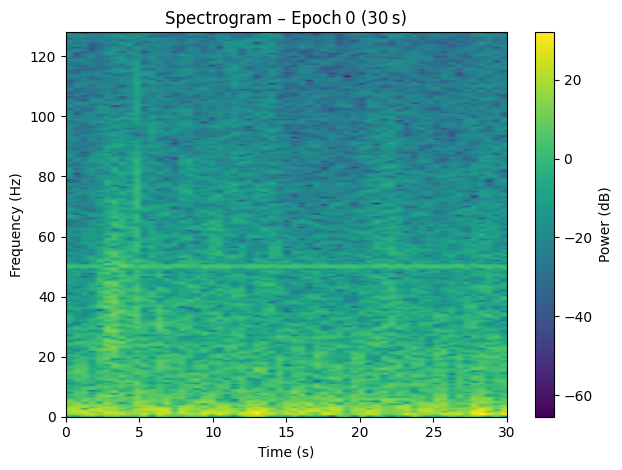

In [ ]:
import numpy as np
from scipy.signal import spectrogram

# ----------------------------------------------------------------------
# 2) SPECTROGRAM – entire 30‑s Epoch 0 for the same channel
# ----------------------------------------------------------------------
epoch0   = signals[chan_idx][:epoch_len]         # 7_680 samples
f, t, Sx = spectrogram(epoch0,
                       fs=sr,
                       nperseg=256,    # 1‑s window
                       noverlap=128,   # 0.5‑s hop
                       nfft=512)       # zero‑pad → 0.5 Hz resolution

Sx_db = 10 * np.log10(Sx + 1e-10)      # convert power to dB take 10*np.log10(Sx + 1e‑10) to 
# express power in decibels (dB). This compresses a huge numeric range into something you 
# can see on a color scale; +10 dB ≈ 10× more power


plt.figure()                                     # separate figure
plt.imshow(Sx_db,
           origin="lower",
           aspect="auto",       # lets freq/time axes scale nicely
           extent=[0, 30, f[0], f[-1]])  # x=0‑30 s, y=0‑128 Hz
plt.colorbar(label="Power (dB)")
plt.title("Spectrogram – Epoch 0 (30 s)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.tight_layout()
plt.show()

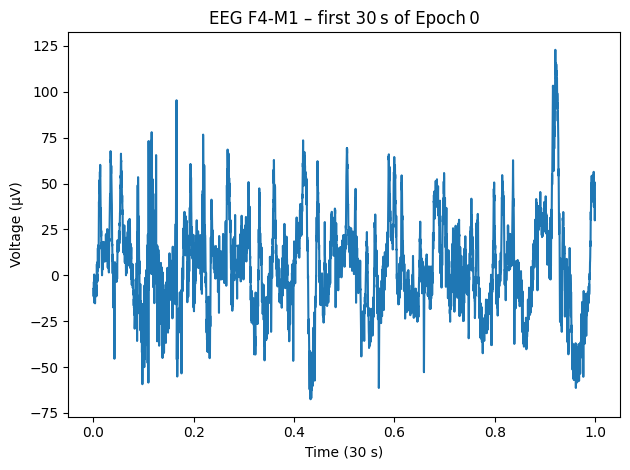

In [37]:
# ----------------------------------------------------------------------
# 1) RAW‑VOLTAGE PLOT – first 1‑s window of Epoch 0
# ----------------------------------------------------------------------
chan_idx = 0  
sr = signal_headers[chan_idx]['sample_frequency'] # e.g. 256.0 Hz
epoch_len = int(30 * sr) # 7680.0 samples per epoch
t_sec         = np.arange(epoch_len) / epoch_len            # time axis in seconds
# first_sec = np.arange(sr)           # time axis in seconds
first30_sec     = signals[chan_idx][:epoch_len] 
# firstsec = signals[chan_idx][:int(sr)] # first 1 second of Epoch 0
plt.figure()                                      # its own figure
plt.plot(t_sec, first30_sec)
# plt.plot(first_sec, firstsec) # plot the first 1 second of Epoch 0
plt.title(f"{signal_headers[chan_idx]['label']} – first 30 s of Epoch 0")
plt.xlabel("Time (30 s)")
plt.ylabel("Voltage (µV)")
plt.tight_layout()                                # cleaner spacing
plt.show()


In [1]:
# signals[0][0:256] # is the first second of raw voltages;

In [38]:
# sr          = signal_headers[0]['sample_rate']   # samples per second
epoch_len   = 30                                 # seconds
n_epochs    = len(labels)                        # should be 855 here
expected_ns = n_epochs * sr * epoch_len
actual_ns   = len(signals[0])

print("expected samples :", expected_ns)
print("actual samples   :", actual_ns)
print("pad needed       :", expected_ns - actual_ns)

expected samples : 6574080.0
actual samples   : 6577408
pad needed       : -3328.0


In [55]:
sr        = 256             # samples / second
win_len   = 256             # samples  = 1 s
hop       = 128             # samples  = 0.5 s
epoch_len = 30 * sr         # 7_680 samples

n_windows = 1 + (epoch_len - win_len) // hop   # = 59

Spectrogram shape: (129, 59)


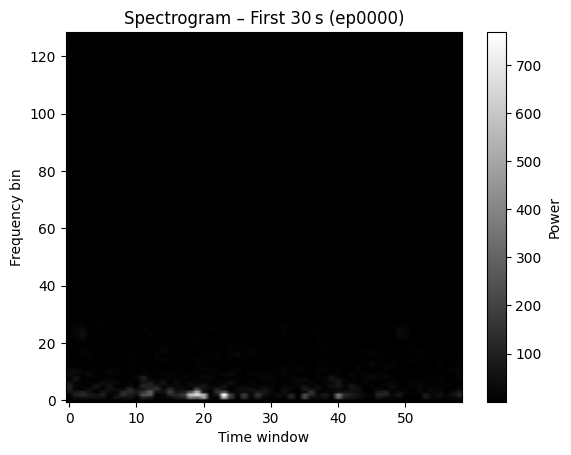

In [40]:
# ----------------------------------------------------------------------
# 3) npy PLOT – look at a single .npy file
# ----------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# Point this to your output directory and a single epoch file
spectro_path = "../dataset/SN001/ep0118.npy"
Sx = np.load(spectro_path)      # shape should be (freq_rows, time_cols)

print("Spectrogram shape:", Sx.shape)
plt.imshow(Sx, origin="lower", aspect="auto", cmap="gray")
plt.title("Spectrogram – First 30 s (ep0000)")
plt.xlabel("Time window")
plt.ylabel("Frequency bin")
plt.colorbar(label="Power")
plt.show()

In [ ]:
def get_frequency_mask(nfft, sr, max_hz):
    """
    Generate a boolean mask to select frequency bins up to max_hz from the FFT output.

    :param nfft: number of FFT points used in spectrogram calculation
    :param sr: sampling rate of the EEG signal
    :param max_hz: maximum frequency to keep in the spectrogram
    :return: boolean numpy array indicating which frequency bins to keep
    """
    # Compute the frequencies corresponding to FFT bins (real FFT frequencies)
    # If SR = 256, then 1/SR = 0.00390625 seconds per sample.
    dummy_f = np.fft.rfftfreq(nfft, 1/sr)
    # Create a boolean mask for frequencies less than or equal to max_hz
    return dummy_f <= max_hz

Your EEG sample rate is 256 Hz, so the __Nyquist__ frequency is 128 Hz (the highest you can meaningfully represent)

__Physiological reason:__
Most relevant sleep EEG features (like delta, theta, alpha, spindle activity, even most muscle artifacts) are well under 64 Hz. Frequencies above that are usually muscle noise, power line noise, or otherwise not informative for sleep staging

__Data/practical reason:__
- Noise: Above 64 Hz, you mostly get noise, not brain activity.
- Data volume: Reducing max Hz keeps your spectrograms smaller and more focused on useful frequencies.
- Convention: Many clinical sleep studies and ML pipelines use 64 Hz as a cutoff for human EEG.

You could keep 128 Hz, but it’s usually extra data with little value for sleep stage classification.

In [52]:
dummy_f = np.fft.rfftfreq(512, 1/256) # shape == (257,)
print(dummy_f[:10]) # == [0. 0.5 1. 1.5 2. 2.5 3. 3.5 4. 4.5]
freq_mask = dummy_f <= 64
# True/false array. true == 0:128 then false == (129:256)
print(np.where(freq_mask)[0]) # == True
# print(np.where(freq_mask == False)[0]) # == False

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128]


In [ ]:
epoch0   = signals[chan_idx][:epoch_len]         # 7_680 samples

f, t, Sx = spectrogram(epoch0,
                        fs=sr, # 256.0 Hz
                        nperseg=256, # 1‑s window
                        noverlap=128, # 0.5‑s hop
                        nfft=512) # zero‑pad → 0.5 Hz resolution
# Sx.shape == (257, 59)
# Apply frequency mask to keep only the desired frequencies
# freq_mask.shape == (257,)
Sx = Sx[freq_mask, :]
# Sx.shape == (129, 59) # ==> (64, 30) for 0.5 Hz resolution
# actually 0 - 64 Hz broken into 129 bins for 0.5 Hz resolution and 0.5 s window

## Train classifier

In [2]:
# ----------------------------------------------------------------------
# 1) Imports and Dataset Class
# ----------------------------------------------------------------------

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

# ------------- Custom Dataset for loading spectrograms -------------
class SleepSpectrogramDataset(Dataset):
    def __init__(self, index_csv, root_dir):
        # Load CSV with epoch info and paths to .npy spectrograms
        df = pd.read_csv(index_csv)
        self.paths = df['path'].tolist()
        self.labels = df['stage'].tolist()
        self.root_dir = Path(root_dir)

        # Label encoding (simple example; adjust as needed)
        label_set = sorted(list(set(self.labels)))
        self.label_to_idx = {lab: idx for idx, lab in enumerate(label_set)}
        self.idx_to_label = {idx: lab for lab, idx in self.label_to_idx.items()}

        # DEBUG: Print mapping for your reference
        print("Label to index mapping:", self.label_to_idx)

    # special Python “dunder” (double-underscore) methods that are required by PyTorch’s Dataset API
    def __len__(self):
        # Number of epochs in dataset
        return len(self.paths)

    def __getitem__(self, idx):
        # Load one spectrogram and label
        # Returns the i-th sample from your dataset (both input and label).
        x = np.load(self.root_dir / self.paths[idx])  # shape: (freq, time)
        x = np.expand_dims(x, axis=0)  # add channel dim: (1, freq, time)
        x = torch.tensor(x, dtype=torch.float32)  # convert to PyTorch tensor
        y = self.label_to_idx[self.labels[idx]]   # convert label to int
        return x, y

In [39]:
index_csv = "../dataset/SN001/index.csv"
root_dir = "../dataset/SN001"

# class SleepSpectrogramDataset(Dataset):
    # def __init__(self, index_csv, root_dir):
        # Load CSV with epoch info and paths to .npy spectrograms
df = pd.read_csv(index_csv)  # (855, 3)
print(df.head(2))  # Check the first few rows of the DataFrame
paths = df['path'].tolist() # 855
labels = df['stage'].tolist()
assert len(paths) == len(labels) # 855
root_dir = Path(root_dir)

# Label encoding (simple example; adjust as needed)
label_set = sorted(list(set(labels))) 
# ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']
label_to_idx = {lab: idx for idx, lab in enumerate(label_set)}
idx_to_label = {idx: lab for lab, idx in label_to_idx.items()}
print("Index to label mapping:", idx_to_label)


   epoch          stage        path
0      0  Sleep stage W  ep0000.npy
1      1  Sleep stage W  ep0001.npy
Index to label mapping: {0: 'Sleep stage N1', 1: 'Sleep stage N2', 2: 'Sleep stage N3', 3: 'Sleep stage R', 4: 'Sleep stage W'}


In [17]:
index_csv = "../dataset/SN001/index.csv"
root_dir = "../dataset/SN001"

dataset = SleepSpectrogramDataset(index_csv, root_dir)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# DataLoader will:
# Use __len__ to figure out the dataset size
# Call __getitem__ over and over to get random samples for each batch

# use them manually, e.g.:
print(len(dataset))        # Calls __len__, returns number of samples
x, y = dataset[5]         # Calls __getitem__(5), returns sample #5

print(x.shape)            # Shape: (1, freq, time)
print(y)                  # Label: int

# almost never call these directly, but they make your custom Dataset “play nice” with PyTorch’s DataLoader and batching


855
torch.Size([1, 129, 59])
4


In [59]:
x, y = dataset[5] # epoch 5
# walthrough of x values (1, freq, time)
# only 1 channel for this example
print(x[0].shape)         # Shape: (freq, time)
# frequencies are buckets of 0.5 Hz ==> since fft set to 512
print("frequcy bin 3 has the power (wiggle strength) of each .5 second window (for 30 seconds of epoch 5) \n for 1.5 hz: "
      , x[0][3]) # frequcy bin 3 has 1.5 hz

torch.Size([129, 59])
frequcy bin 3 has the power (wiggle strength) of each .5 second window (for 30 seconds of epoch 5) 
 for 1.5 hz:  tensor([ 1.7832,  9.9152,  3.9536,  6.5153, 71.9927,  4.0944, 24.6098, 28.1349,
         3.4138, 17.0178,  5.6000,  0.2142,  2.5453, 34.3999,  5.3688, 18.5432,
        25.4958,  5.6408,  1.5156,  3.7654,  3.0887, 17.3001,  6.3321,  9.5749,
         0.1057,  3.9745,  0.5044,  8.7415,  6.7056, 15.4323, 13.0051,  2.3820,
         0.3231, 46.9446,  5.8749, 39.1533,  4.4697,  5.5892, 55.3334, 28.6561,
         3.3479, 27.5865,  0.5722,  4.1741,  3.2098, 11.4396,  2.0814,  8.1689,
        21.4660,  0.3912, 32.0285, 20.3064,  0.6834, 10.9214,  7.6604, 26.8446,
         6.9276,  0.1320, 13.1139])


In [60]:
# ----------------------------------------------------------------------
# 2) Define a Simple CNN Model
# ----------------------------------------------------------------------

# ---- Simple CNN for classifying sleep stages from spectrograms ----
class SimpleSleepCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Conv layer 1: (in_channels=1, out_channels=16, kernel=3x3)
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        # Conv layer 2: (in_channels=16, out_channels=32, kernel=3x3)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # MaxPool layer (reduces spatial dims by half each time)
        self.pool = nn.MaxPool2d(2)

        # Fully connected layers
        # Flattening will depend on input shape; adjust if shape mismatch
        # Example: input spectrogram (1, 128, 59) --> pool --> (32, 32, 14) after 2 pools
        self.fc1 = nn.Linear(32 * 32 * 14, 64)   # adjust these numbers to match your actual output shape!
        self.fc2 = nn.Linear(64, n_classes)

    def forward(self, x):
        # x: (batch, channels, freq, time)
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        # Debug: print output shape after conv/pool
        print("Shape before flatten:", x.shape)
        x = x.view(x.size(0), -1)  # flatten all but batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    # The fc1 input size must match the output shape after pooling. Adjust as needed for your actual input size!

In [61]:
import torch
import torch.nn as nn

# Let's suppose your spectrogram input shape is (1, 129, 59)
# Simulate a batch of 1 sample for walkthrough:
x = torch.randn(1, 1, 129, 59)  # (batch, channel, freq, time)
print("Input shape:", x.shape)

# Define layers exactly as in your model:
conv1 = nn.Conv2d(1, 16, 3, padding=1)
conv2 = nn.Conv2d(16, 32, 3, padding=1)
pool = nn.MaxPool2d(2)

# --- 1st convolutional layer ---
x1 = conv1(x)
print("After conv1:", x1.shape)
# Each of the 16 output channels is a learned 3x3 filter sliding over input

# --- ReLU activation ---
relu1 = torch.relu(x1)
print("After ReLU1:", relu1.shape)
# ReLU sets all negative numbers to 0: relu(x) = max(0, x)
# It adds non-linearity, letting the network learn more complex things.

# --- 1st pooling layer ---
pool1 = pool(relu1)
print("After pool1:", pool1.shape)
# MaxPool2d(2) reduces each 2x2 block to its max value (halves each spatial dim)

# --- 2nd convolutional layer ---
x2 = conv2(pool1)
print("After conv2:", x2.shape)
# Now 32 output channels, same 3x3 filters

# --- ReLU again ---
relu2 = torch.relu(x2)
print("After ReLU2:", relu2.shape)

# --- 2nd pooling layer ---
pool2 = pool(relu2)
print("After pool2:", pool2.shape)
# Shape should now be (batch, 32, new_freq, new_time)

# --- Flatten for the fully connected (FC) layer ---
flatten = pool2.view(pool2.size(0), -1)
print("After flattening:", flatten.shape)
# This turns 4D tensor (batch, channels, freq, time) into 2D (batch, all_features)

# --- First fully connected layer (example output size: 64) ---
fc1 = nn.Linear(flatten.shape[1], 64)
fc1_out = torch.relu(fc1(flatten))
print("After FC1 (and ReLU):", fc1_out.shape)

# --- Final output layer (let's say 5 classes) ---
fc2 = nn.Linear(64, 5)
out = fc2(fc1_out)
print("Final output (logits):", out.shape)
# Output shape: (batch, num_classes), one score for each class

# --- Optionally: softmax to get probabilities ---
probs = torch.softmax(out, dim=1)
print("Predicted probabilities:", probs)
print("Sum of probs (should be 1.0):", probs.sum(dim=1))

Input shape: torch.Size([1, 1, 129, 59])
After conv1: torch.Size([1, 16, 129, 59])
After ReLU1: torch.Size([1, 16, 129, 59])
After pool1: torch.Size([1, 16, 64, 29])
After conv2: torch.Size([1, 32, 64, 29])
After ReLU2: torch.Size([1, 32, 64, 29])
After pool2: torch.Size([1, 32, 32, 14])
After flattening: torch.Size([1, 14336])
After FC1 (and ReLU): torch.Size([1, 64])
Final output (logits): torch.Size([1, 5])
Predicted probabilities: tensor([[0.1712, 0.2137, 0.1747, 0.2161, 0.2243]], grad_fn=<SoftmaxBackward0>)
Sum of probs (should be 1.0): tensor([1.0000], grad_fn=<SumBackward1>)


In [4]:
# ----------------------------------------------------------------------
# 3) Training Loop (Bare Bones)
# ----------------------------------------------------------------------

def train_one_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [9]:
# ----------------------------------------------------------------------
# 4) Main Script
# ----------------------------------------------------------------------

def main():
    # Config
    index_csv = "../dataset/SN001/index.csv"
    root_dir = "../dataset/SN001"
    batch_size = 16
    epochs = 10
    lr = 1e-3

    # Dataset and loader
    dataset = SleepSpectrogramDataset(index_csv, root_dir)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Model
    n_classes = len(set(dataset.labels))
    model = SimpleSleepCNN(n_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Training setup
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
        loss = train_one_epoch(model, loader, loss_fn, optimizer, device)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

    # Save model
    torch.save(model.state_dict(), "sleep_cnn.pth")
    print("Training done, model saved.")

# if __name__ == "__main__":
#     main()



In [10]:
main()

Epoch 1/10, Loss: 23.0154
Epoch 2/10, Loss: 2.5282
Epoch 3/10, Loss: 1.5671
Epoch 4/10, Loss: 1.1635
Epoch 5/10, Loss: 0.8937
Epoch 6/10, Loss: 0.7337
Epoch 7/10, Loss: 0.6109
Epoch 8/10, Loss: 0.5856
Epoch 9/10, Loss: 0.7500
Epoch 10/10, Loss: 1.3053
Training done, model saved.
